This notebook is part of the AI Engineer Track Challenge for Digital Product School. Please see the repository at https://github.com/diksha-shrivastava13/Traffic-Accidents-Model
This notebook contains the models.

# The Necessary Imports, Loading Data and W&B Configuration

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import wandb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

# Statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess

# NumPy and SciPy
from numpy.random import normal, seed
from scipy.stats import norm

# Scikit-Learn
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, r2_score

# XGBoost and LightGBM
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, LGBMClassifier

# Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Meta Prophet
from prophet import Prophet

### Configuring wandb for the notebook.

In [2]:
# setting up wandb integration
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb-api")
wandb.login(key=wandb_api)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
# extract the latest version of the dataset from W&B
run = wandb.init(project="traffic-accidents", job_type="update-dataset")
artifact = run.use_artifact("preprocessed_dataset:latest")
artifact_dir = artifact.download()
df = pd.read_csv(f"{artifact_dir}/preprocessed_dataset.csv")
wandb.finish()

wandb: Currently logged in as: diksha-shrivastava13. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231205_181124-fu5kyp15
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run misty-wind-82
wandb: ⭐️ View project at https://wandb.ai/diksha-shrivastava13/traffic-accidents
wandb: 🚀 View run at https://wandb.ai/diksha-shrivastava13/traffic-accidents/runs/fu5kyp15
wandb:   1 of 1 files downloaded.  
wandb:                                                                                
wandb: 🚀 View run misty-wind-82 at: https://wandb.ai/diksha-shrivastava13/traffic-accidents/runs/fu5kyp15
wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20231205_181124-fu5kyp15/logs


### Heading Towards Train Test Split

In [4]:
df.head()

,YEAR,MONTH,VALUE,Date,Month Count_Alcohol Accidents,Month Count_Escape accidents,Month Count_Traffic Accidents,CHARACTERISTIC_Injured and killed,CHARACTERISTIC_total,CHARACTERISTIC_with personal injury
0,2020,1,28.0,2020-01-01,1,0,0,0,1,0
1,2020,2,40.0,2020-02-01,1,0,0,0,1,0
2,2020,3,27.0,2020-03-01,1,0,0,0,1,0
3,2020,4,26.0,2020-04-01,1,0,0,0,1,0
4,2020,5,40.0,2020-05-01,1,0,0,0,1,0


In [5]:
df.shape

(1760, 10)

In [6]:
df_sorted = df.sort_values(by='Date')
train_percentage = 0.8
split_index = int(len(df_sorted) * train_percentage)
train_set = df_sorted[:split_index]
test_set = df_sorted[split_index:]
train_set = train_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

In [7]:
train_set

,YEAR,MONTH,VALUE,Date,Month Count_Alcohol Accidents,Month Count_Escape accidents,Month Count_Traffic Accidents,CHARACTERISTIC_Injured and killed,CHARACTERISTIC_total,CHARACTERISTIC_with personal injury
0,2000,1,34.0,2000-01-01,0,1,0,1,0,0
1,2000,1,37.0,2000-01-01,1,0,0,1,0,0
2,2000,1,835.0,2000-01-01,0,1,0,0,1,0
3,2000,1,321.0,2000-01-01,0,0,1,0,0,1
4,2000,1,78.0,2000-01-01,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
1403,2016,10,559.0,2016-10-01,0,0,1,1,0,0
1404,2016,10,1022.0,2016-10-01,0,1,0,0,1,0
1405,2016,10,4297.0,2016-10-01,0,0,1,0,1,0
1406,2016,10,44.0,2016-10-01,0,1,0,1,0,0


In [8]:
test_set

,YEAR,MONTH,VALUE,Date,Month Count_Alcohol Accidents,Month Count_Escape accidents,Month Count_Traffic Accidents,CHARACTERISTIC_Injured and killed,CHARACTERISTIC_total,CHARACTERISTIC_with personal injury
0,2016,10,448.0,2016-10-01,0,0,1,0,0,1
1,2016,10,30.0,2016-10-01,1,0,0,0,1,0
2,2016,11,7.0,2016-11-01,1,0,0,1,0,0
3,2016,11,489.0,2016-11-01,0,0,1,1,0,0
4,2016,11,960.0,2016-11-01,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
347,2020,12,33.0,2020-12-01,0,1,0,1,0,0
348,2020,12,311.0,2020-12-01,0,0,1,1,0,0
349,2020,12,2661.0,2020-12-01,0,0,1,0,1,0
350,2020,12,694.0,2020-12-01,0,1,0,0,1,0


In [9]:
X_train, y_train = train_set.drop(columns=["Date", "VALUE"]), train_set["VALUE"]
X_test, y_test = test_set.drop(columns=["Date", "VALUE"]), test_set["VALUE"]

In [10]:
np.array(X_train)[0]

array([2000,    1,    0,    1,    0,    1,    0,    0])

In [11]:
np.array(y_train)[0]

34.0

# Linear Regression Model

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
lr.score(X_train, y_train)

0.7266540248986035

In [13]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Linear Regression RMSE: {rmse}")

# Calculate R2 Score
r2 = r2_score(y_test, y_pred)
print(f"Linear Regression R2 Score: {r2}")

Linear Regression RMSE: 652.3649192609317
Linear Regression R2 Score: 0.7182540867105955


In [14]:
print(y_test[0], y_pred[0])

448.0 486.04912388092544


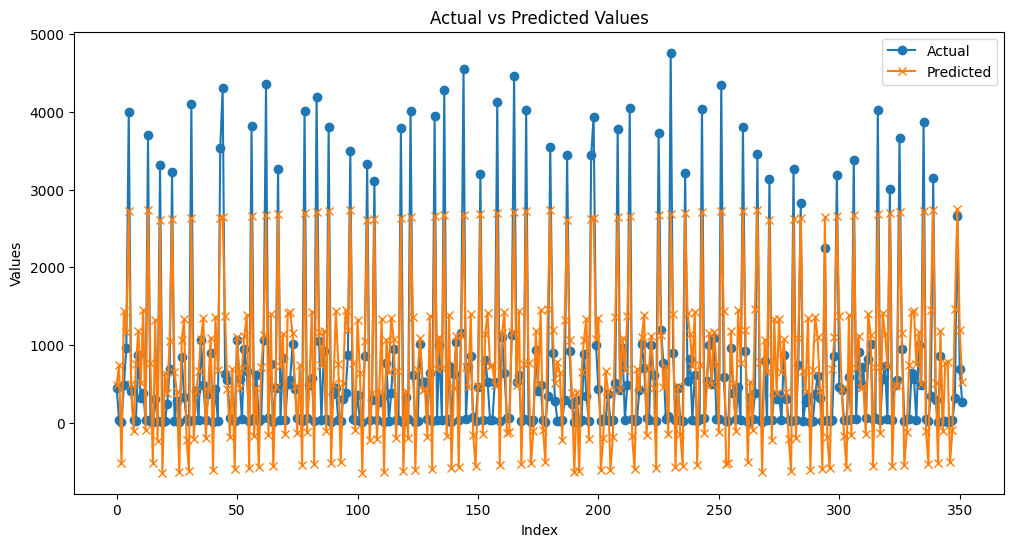

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

# Poisson Regression Model

In [16]:
# Fit Poisson Regression model
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

# Predict on the test set
y_pred = poisson_model.predict(X_test)

# Evaluate the model
mse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(poisson_model.summary())

Root Mean Squared Error: 216.49672043877882
R-squared: 0.9689701932188256
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  VALUE   No. Observations:                 1408
Model:                            GLM   Df Residuals:                     1401
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -29089.
Date:                Tue, 05 Dec 2023   Deviance:                       48041.
Time:                        18:12:23   Pearson chi2:                 4.98e+04
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

In [17]:
print(y_test[0], y_pred[0])

448.0 459.42163266633935


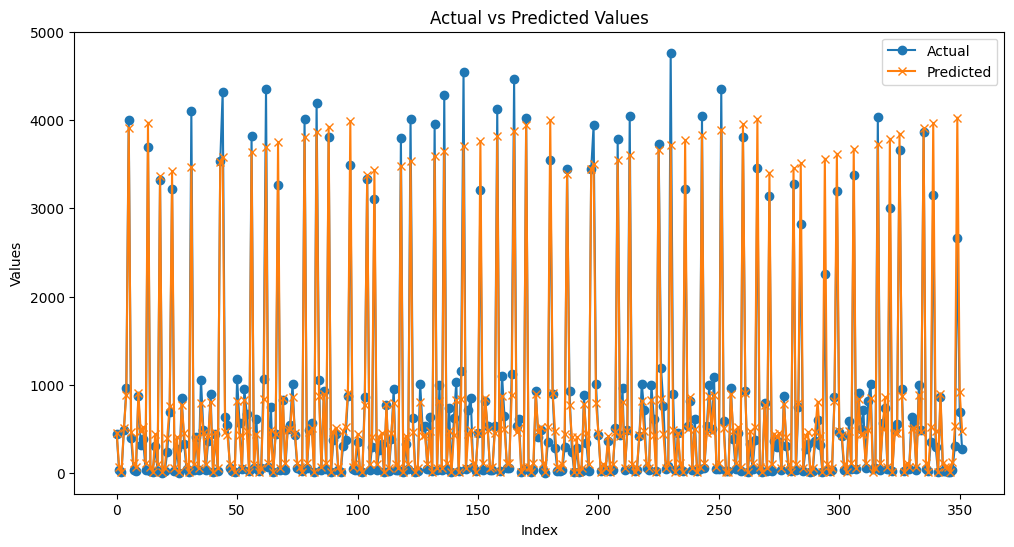

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

# Multi-Layer Perceptron Regressor

In [19]:
mlp_regressor = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

# Fit the model
mlp_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = mlp_regressor.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared (R2) Score: {r2:.4f}')

Root Mean Squared Error (RMSE): 1228.6881
R-squared (R2) Score: 0.0006


In [20]:
print(y_test[0], y_pred[0])

448.0 759.5081666940281


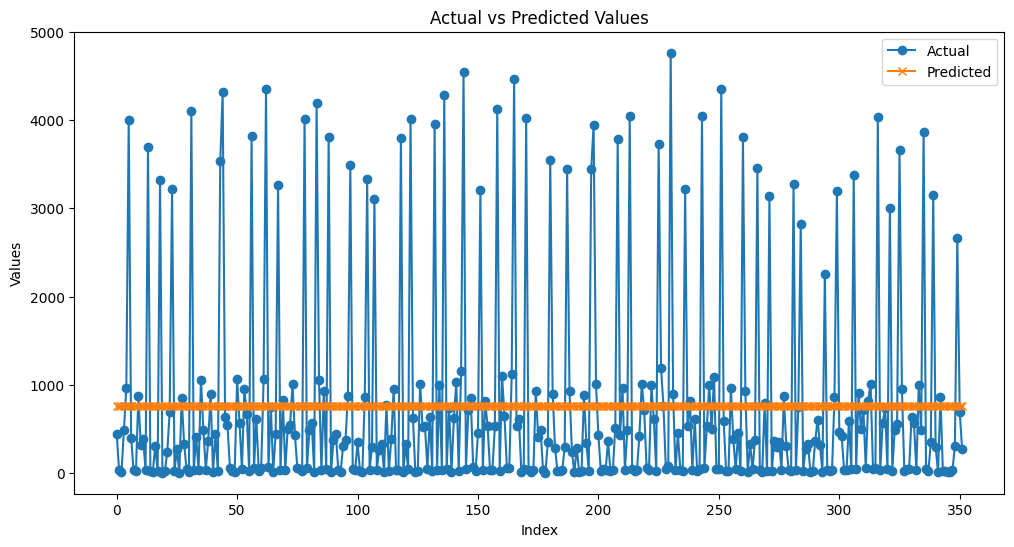

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

# XGBoost

In [22]:
from xgboost import XGBRegressor as xgb
import joblib

model = XGBRegressor(
    max_depth=5,
    n_estimators=415,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse",  
    verbose=True)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared (R2) Score: {r2:.4f}')

Root Mean Squared Error (RMSE): 179.2515
R-squared (R2) Score: 0.9787


In [23]:
X_train

,YEAR,MONTH,Month Count_Alcohol Accidents,Month Count_Escape accidents,Month Count_Traffic Accidents,CHARACTERISTIC_Injured and killed,CHARACTERISTIC_total,CHARACTERISTIC_with personal injury
0,2000,1,0,1,0,1,0,0
1,2000,1,1,0,0,1,0,0
2,2000,1,0,1,0,0,1,0
3,2000,1,0,0,1,0,0,1
4,2000,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...
1403,2016,10,0,0,1,1,0,0
1404,2016,10,0,1,0,0,1,0
1405,2016,10,0,0,1,0,1,0
1406,2016,10,0,1,0,1,0,0


### BentoML Checks

In [24]:
model.save_model('model_file_name.json')

In [25]:
model = xgb()
model.load_model("model_file_name.json")

In [26]:
!pip install bentoml

  Obtaining dependency information for bentoml from https://files.pythonhosted.org/packages/fc/50/5a1e031d4f664724ee0583b0cca18f483b908eda53dfed41a8506f732290/bentoml-1.1.10-py3-none-any.whl.metadata
  Obtaining dependency information for cattrs<23.2.0,>=22.1.0 from https://files.pythonhosted.org/packages/3a/ba/05df14efaa0624fac6b1510e87f5ce446208d2f6ce50270a89b6268aebfe/cattrs-23.1.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 10.8 MB/s eta 0:00:00
  Obtaining dependency information for click-option-group from https://files.pythonhosted.org/packages/af/75/81ea958bc0f7e410257cb2a42531b93a7695a31930cde87192c010a52c50/click_option_group-0.5.6-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 11.6 MB/s eta 0:00:00
  Obtaining dependency information for httpx from https://files.pythonhosted.org/packages/a2/65/6940eeb21dcb2953778a6895281c179efd9100463ff08cb6232bb6480da7/httpx-0.25.2-py3-none-any.whl.metadata
  Obtai

In [27]:
import bentoml
bento_model = bentoml.xgboost.save_model("my_xgboost_model", model)

In [28]:
loaded_model = bentoml.xgboost.load_model("my_xgboost_model")

In [29]:
loaded_model.predict([[2000,    1,    0,    1,    0,    1,    0,    0]])

array([26.025667], dtype=float32)

In [30]:
loaded_model.predict([[2021,    10,    0,    0,    1,    1,    0,    0]])

array([577.5168], dtype=float32)

In [31]:
loaded_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['int', 'int', 'int', 'int', 'int', 'int', 'int',
                            'int'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

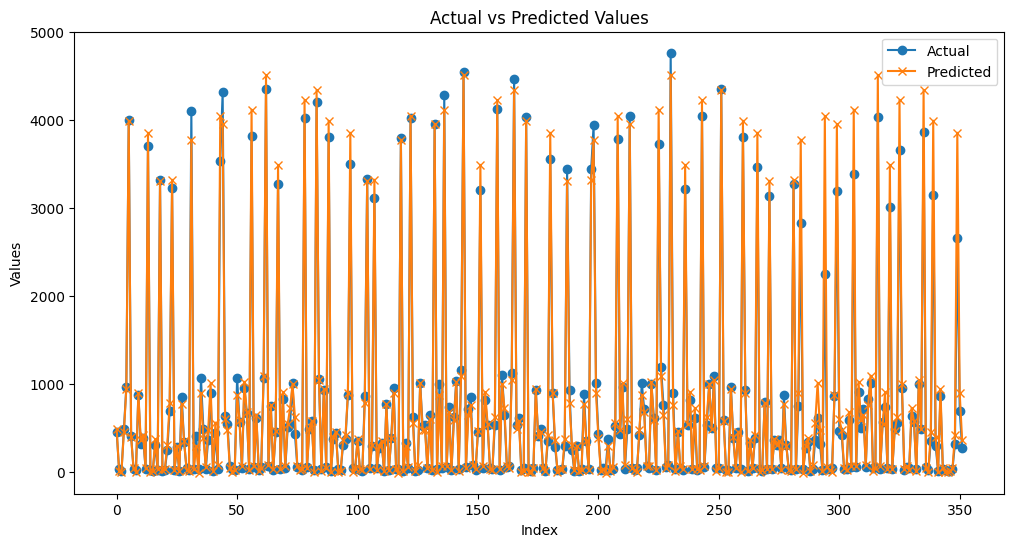

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

# LightGBM Model

In [33]:
import lightgbm as lgb

In [34]:
# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Define parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',  # You can use other metrics like 'mse', 'mae', etc.
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the LightGBM model
num_round = 1000
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data], early_stopping_rounds=20)

# Make predictions on the test set
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared (R2) Score: {r2:.4f}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 776.551136
[1]	valid_0's rmse: 1166.01
Training until validation scores don't improve for 20 rounds
[2]	valid_0's rmse: 1111.91
[3]	valid_0's rmse: 1054.67
[4]	valid_0's rmse: 1005.98
[5]	valid_0's rmse: 954.213
[6]	valid_0's rmse: 905.127
[7]	valid_0's rmse: 858.594
[8]	valid_0's rmse: 814.442
[9]	valid_0's rmse: 772.662
[10]	valid_0's rmse: 732.947
[11]	valid_0's rmse: 695.47
[12]	valid_0's rmse: 663.609
[13]	valid_0's rmse: 633.45
[14]	v

In [35]:
print(y_test[70], y_pred[70])

38.0 76.86742817760502


In [36]:
y_pred_train = bst.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)

print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared (R2) Score: {r2:.4f}')

Root Mean Squared Error (RMSE): 116.9353
R-squared (R2) Score: 0.9900


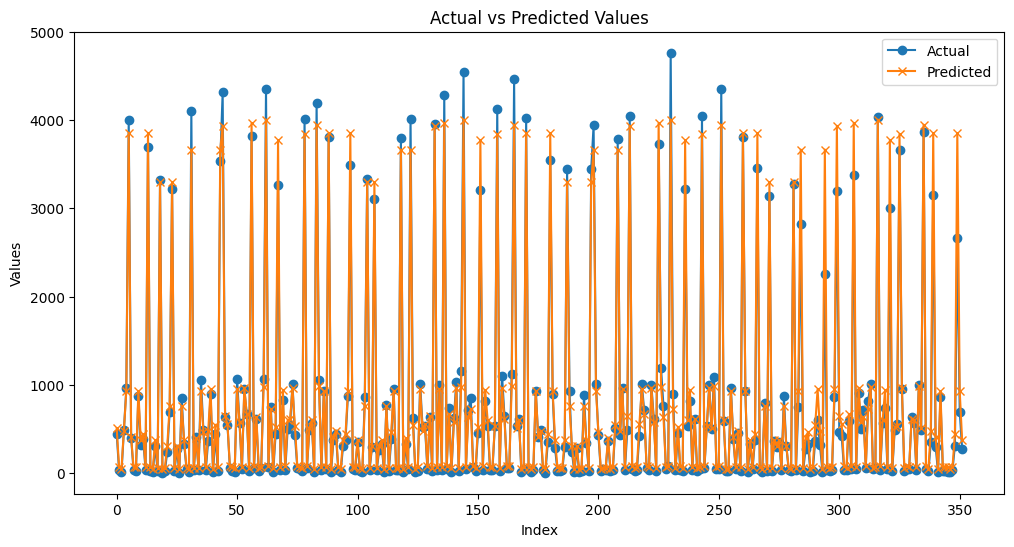

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

# KFold Validation on XGBoost

In [38]:
X = df.drop(columns=["Date", "VALUE"])
y = df["VALUE"]

In [39]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming you have your features and target variable in X and y

# Set the parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # For regression tasks
    'eval_metric': 'rmse',  # Root Mean Squared Error as the evaluation metric
    'max_depth': 5,  # Maximum depth of each tree
    'learning_rate': 0.1,  # Learning rate
    'subsample': 0.8,  # Subsample ratio of the training instance
    'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
    'seed': 42
}

# Specify the number of folds
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store evaluation metrics for each fold
rmse_scores = []
r2_scores = []

# Iterate through each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create XGBoost DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Train the XGBoost model
    model = xgb.train(params, dtrain, num_boost_round=1000, evals=[(dtest, 'eval')], early_stopping_rounds=10, verbose_eval=False)

    # Make predictions
    y_pred = model.predict(dtest)

    # Calculate and store evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

# Print average scores across all folds
print(f'Average RMSE across {num_folds} folds: {np.mean(rmse_scores)}')
print(f'Average R2 score across {num_folds} folds: {np.mean(r2_scores)}')
print(r2_scores)


Average RMSE across 5 folds: 97.322005167473
Average R2 score across 5 folds: 0.9930616963588698
[0.9919417144207033, 0.9907527838761054, 0.9930509936984218, 0.9953276676118424, 0.9942353221872765]


# Prophet Models

### Some Preprocessing Steps

In [40]:
# extract the latest version of the dataset from W&B
run = wandb.init(project="traffic-accidents", job_type="update-dataset")
artifact = run.use_artifact("dataset:latest")
artifact_dir = artifact.download()
df = pd.read_csv(f"{artifact_dir}/translated_dataset.csv")
wandb.finish()

wandb: Tracking run with wandb version 0.16.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231205_181256-gqnqighv
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run glorious-wind-83
wandb: ⭐️ View project at https://wandb.ai/diksha-shrivastava13/traffic-accidents
wandb: 🚀 View run at https://wandb.ai/diksha-shrivastava13/traffic-accidents/runs/gqnqighv
wandb:   1 of 1 files downloaded.  
wandb:                                                                                
wandb: 🚀 View run glorious-wind-83 at: https://wandb.ai/diksha-shrivastava13/traffic-accidents/runs/gqnqighv
wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20231205_181256-gqnqighv/logs


In [41]:
df.head()

,Month Count,CHARACTERISTIC,YEAR,MONTH,VALUE,PREVIOUS YEAR'S VALUE,Change Previous Month Percentage,Change Previous Year's Month,TWELVE_MONTHS_MEAN
0,Alcohol Accidents,total,2023,202301,NaN,NaN,NaN,NaN,NaN
1,Alcohol Accidents,total,2023,202302,NaN,NaN,NaN,NaN,NaN
2,Alcohol Accidents,total,2023,202303,NaN,NaN,NaN,NaN,NaN
3,Alcohol Accidents,total,2023,202304,NaN,NaN,NaN,NaN,NaN
4,Alcohol Accidents,total,2023,202305,NaN,NaN,NaN,NaN,NaN


In [42]:
df.dtypes

Month Count                          object
CHARACTERISTIC                       object
YEAR                                  int64
MONTH                                 int64
VALUE                               float64
PREVIOUS YEAR'S VALUE               float64
Change Previous Month Percentage    float64
Change Previous Year's Month        float64
TWELVE_MONTHS_MEAN                  float64
dtype: object

In [43]:
df['MONTH'] = df['MONTH'] % 100
df['ds'] = pd.to_datetime(df[['YEAR', 'MONTH']].assign(DAY=1))
df.drop(['YEAR', 'MONTH'], axis=1, inplace=True)
df.rename(columns={'VALUE': 'y'}, inplace=True)

In [44]:
df.head()

,Month Count,CHARACTERISTIC,y,PREVIOUS YEAR'S VALUE,Change Previous Month Percentage,Change Previous Year's Month,TWELVE_MONTHS_MEAN,ds
0,Alcohol Accidents,total,NaN,NaN,NaN,NaN,NaN,2023-01-01
1,Alcohol Accidents,total,NaN,NaN,NaN,NaN,NaN,2023-02-01
2,Alcohol Accidents,total,NaN,NaN,NaN,NaN,NaN,2023-03-01
3,Alcohol Accidents,total,NaN,NaN,NaN,NaN,NaN,2023-04-01
4,Alcohol Accidents,total,NaN,NaN,NaN,NaN,NaN,2023-05-01


In [45]:
df.dtypes

Month Count                                 object
CHARACTERISTIC                              object
y                                          float64
PREVIOUS YEAR'S VALUE                      float64
Change Previous Month Percentage           float64
Change Previous Year's Month               float64
TWELVE_MONTHS_MEAN                         float64
ds                                  datetime64[ns]
dtype: object

In [46]:
df = df.drop(columns=["PREVIOUS YEAR'S VALUE", 'Change Previous Month Percentage', "Change Previous Year's Month", 'TWELVE_MONTHS_MEAN'])
df = df[df['ds'].dt.year <= 2020]
df['Month Count'] = df['Month Count'].replace({'Accidents, Traffic': 'Traffic Accidents'})
df = df.sort_values(by='ds')

In [47]:
df.head()

,Month Count,CHARACTERISTIC,y,ds
1140,Escape accidents,Injured and killed,34.0,2000-01-01
1716,Traffic Accidents,with personal injury,321.0,2000-01-01
276,Alcohol Accidents,total,78.0,2000-01-01
852,Escape accidents,total,835.0,2000-01-01
1428,Traffic Accidents,total,3448.0,2000-01-01


In [48]:
df_alcohol = df[df['Month Count'] == "Alcohol Accidents"]
df_escape = df[df['Month Count'] == "Escape accidents"]
df_traffic = df[df['Month Count'] == "Traffic Accidents"]

In [49]:
df_traffic

,Month Count,CHARACTERISTIC,y,ds
1716,Traffic Accidents,with personal injury,321.0,2000-01-01
1428,Traffic Accidents,total,3448.0,2000-01-01
2004,Traffic Accidents,Injured and killed,434.0,2000-01-01
1717,Traffic Accidents,with personal injury,329.0,2000-02-01
1429,Traffic Accidents,total,3181.0,2000-02-01
...,...,...,...,...
1774,Traffic Accidents,Injured and killed,348.0,2020-11-01
1198,Traffic Accidents,total,3150.0,2020-11-01
1775,Traffic Accidents,Injured and killed,311.0,2020-12-01
1199,Traffic Accidents,total,2661.0,2020-12-01


In [50]:
df_escape

,Month Count,CHARACTERISTIC,y,ds
1140,Escape accidents,Injured and killed,34.0,2000-01-01
852,Escape accidents,total,835.0,2000-01-01
1141,Escape accidents,Injured and killed,35.0,2000-02-01
853,Escape accidents,total,890.0,2000-02-01
1142,Escape accidents,Injured and killed,48.0,2000-03-01
...,...,...,...,...
909,Escape accidents,Injured and killed,50.0,2020-10-01
910,Escape accidents,Injured and killed,27.0,2020-11-01
622,Escape accidents,total,864.0,2020-11-01
623,Escape accidents,total,694.0,2020-12-01


In [51]:
df_alcohol

,Month Count,CHARACTERISTIC,y,ds
276,Alcohol Accidents,total,78.0,2000-01-01
564,Alcohol Accidents,Injured and killed,37.0,2000-01-01
277,Alcohol Accidents,total,53.0,2000-02-01
565,Alcohol Accidents,Injured and killed,19.0,2000-02-01
278,Alcohol Accidents,total,73.0,2000-03-01
...,...,...,...,...
45,Alcohol Accidents,total,34.0,2020-10-01
46,Alcohol Accidents,total,23.0,2020-11-01
334,Alcohol Accidents,Injured and killed,11.0,2020-11-01
335,Alcohol Accidents,Injured and killed,9.0,2020-12-01


### Alcohol Model

In [52]:
model_alcohol = Prophet()
model_alcohol.fit(df_alcohol)

18:13:54 - cmdstanpy - INFO - Chain [1] start processing
18:13:54 - cmdstanpy - INFO - Chain [1] done processing


In [53]:
future_alcohol = model_alcohol.make_future_dataframe(periods=12, freq='30d')
forecast = model_alcohol.predict(future_alcohol)

In [54]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-01-01,53.420178,26.010555,61.634513,53.420178,53.420178,-9.373007,-9.373007,-9.373007,-9.373007,-9.373007,-9.373007,0.0,0.0,0.0,44.047171
1,2000-02-01,53.195907,24.419995,60.516630,53.195907,53.195907,-11.030748,-11.030748,-11.030748,-11.030748,-11.030748,-11.030748,0.0,0.0,0.0,42.165159
2,2000-03-01,52.986105,27.207952,62.449045,52.986105,52.986105,-7.514685,-7.514685,-7.514685,-7.514685,-7.514685,-7.514685,0.0,0.0,0.0,45.471421
3,2000-04-01,52.761834,31.948480,68.373229,52.761834,52.761834,-3.765715,-3.765715,-3.765715,-3.765715,-3.765715,-3.765715,0.0,0.0,0.0,48.996120
4,2000-05-01,52.544798,39.929137,77.121706,52.544798,52.544798,6.637874,6.637874,6.637874,6.637874,6.637874,6.637874,0.0,0.0,0.0,59.182672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2021-07-29,23.984763,9.280328,45.606407,23.945111,24.025318,3.122722,3.122722,3.122722,3.122722,3.122722,3.122722,0.0,0.0,0.0,27.107486
260,2021-08-28,23.978500,12.336857,49.057186,23.930384,24.029695,7.828636,7.828636,7.828636,7.828636,7.828636,7.828636,0.0,0.0,0.0,31.807135
261,2021-09-27,23.972236,8.797020,45.218710,23.912868,24.036694,4.328134,4.328134,4.328134,4.328134,4.328134,4.328134,0.0,0.0,0.0,28.300370
262,2021-10-27,23.965972,9.296682,46.128808,23.897411,24.041712,3.478389,3.478389,3.478389,3.478389,3.478389,3.478389,0.0,0.0,0.0,27.444362


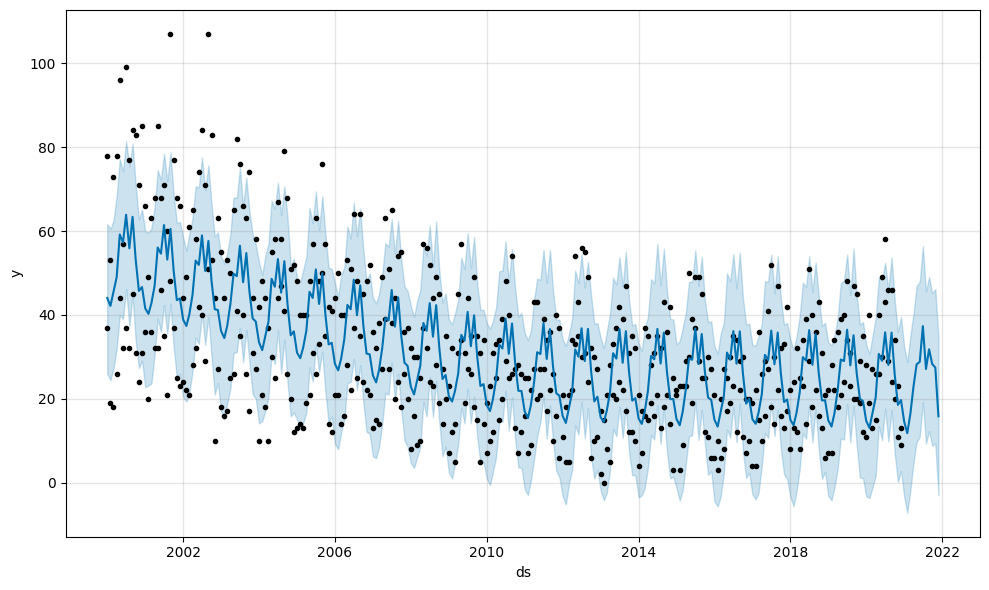

In [55]:
fig_alcohol = model_alcohol.plot(forecast)

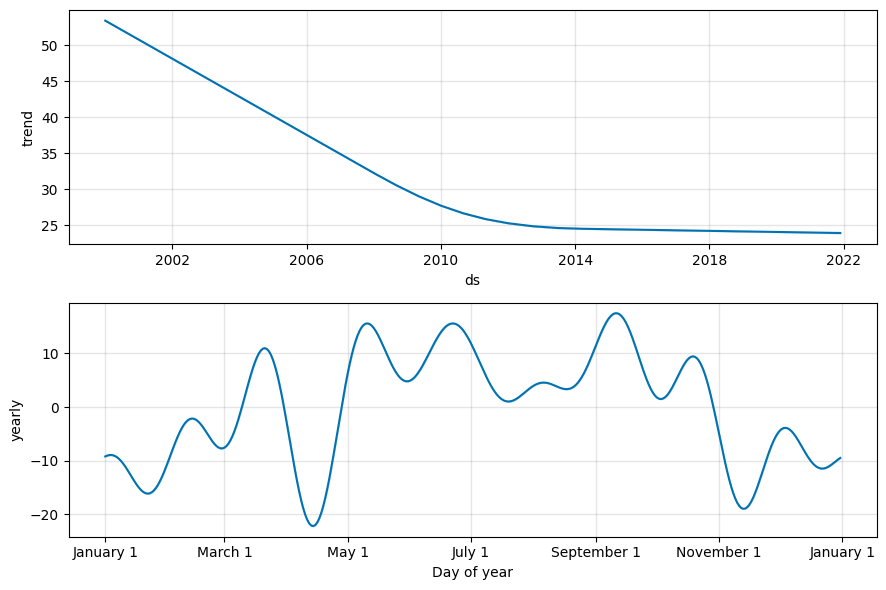

In [56]:
fig2 = model_alcohol.plot_components(forecast)

In [57]:
import pickle
with open('model_alcohol.pkl', 'wb') as model_file:
    pickle.dump(model_alcohol, model_file)

## Escape Model

In [58]:
df_escape.describe()

,y,ds
count,504.000000,504
mean,462.158730,2010-06-16 14:17:08.571428608
min,17.000000,2000-01-01 00:00:00
25%,43.000000,2005-03-24 06:00:00
50%,248.000000,2010-06-16 00:00:00
75%,876.250000,2015-09-08 12:00:00
max,1187.000000,2020-12-01 00:00:00
std,428.597712,NaN


In [59]:
model_escape = Prophet()
model_escape.fit(df_escape)

18:13:58 - cmdstanpy - INFO - Chain [1] start processing
18:13:58 - cmdstanpy - INFO - Chain [1] done processing


In [60]:
future_escape = model_escape.make_future_dataframe(periods=12, freq="30d")
forecast_escape = model_escape.predict(future_escape)

In [61]:
forecast_escape

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-01-01,429.678569,-175.856897,942.617922,429.678569,429.678569,-65.249867,-65.249867,-65.249867,-65.249867,-65.249867,-65.249867,0.0,0.0,0.0,364.428702
1,2000-02-01,429.908257,-174.944246,916.876912,429.908257,429.908257,-61.533410,-61.533410,-61.533410,-61.533410,-61.533410,-61.533410,0.0,0.0,0.0,368.374847
2,2000-03-01,430.123127,-71.727660,996.780165,430.123127,430.123127,0.167705,0.167705,0.167705,0.167705,0.167705,0.167705,0.0,0.0,0.0,430.290833
3,2000-04-01,430.352816,-129.979576,1001.356671,430.352816,430.352816,-0.419314,-0.419314,-0.419314,-0.419314,-0.419314,-0.419314,0.0,0.0,0.0,429.933501
4,2000-05-01,430.575095,-152.614741,975.820606,430.575095,430.575095,13.063017,13.063017,13.063017,13.063017,13.063017,13.063017,0.0,0.0,0.0,443.638112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2021-07-29,488.063904,-91.612203,970.875331,488.063904,488.063904,-36.693508,-36.693508,-36.693508,-36.693508,-36.693508,-36.693508,0.0,0.0,0.0,451.370396
260,2021-08-28,488.286183,11.966617,1077.187246,488.286183,488.286184,50.613649,50.613649,50.613649,50.613649,50.613649,50.613649,0.0,0.0,0.0,538.899833
261,2021-09-27,488.508463,-21.275750,1104.849037,488.508462,488.508463,57.331019,57.331019,57.331019,57.331019,57.331019,57.331019,0.0,0.0,0.0,545.839481
262,2021-10-27,488.730742,-61.191548,1037.831247,488.730741,488.730742,-4.104960,-4.104960,-4.104960,-4.104960,-4.104960,-4.104960,0.0,0.0,0.0,484.625782


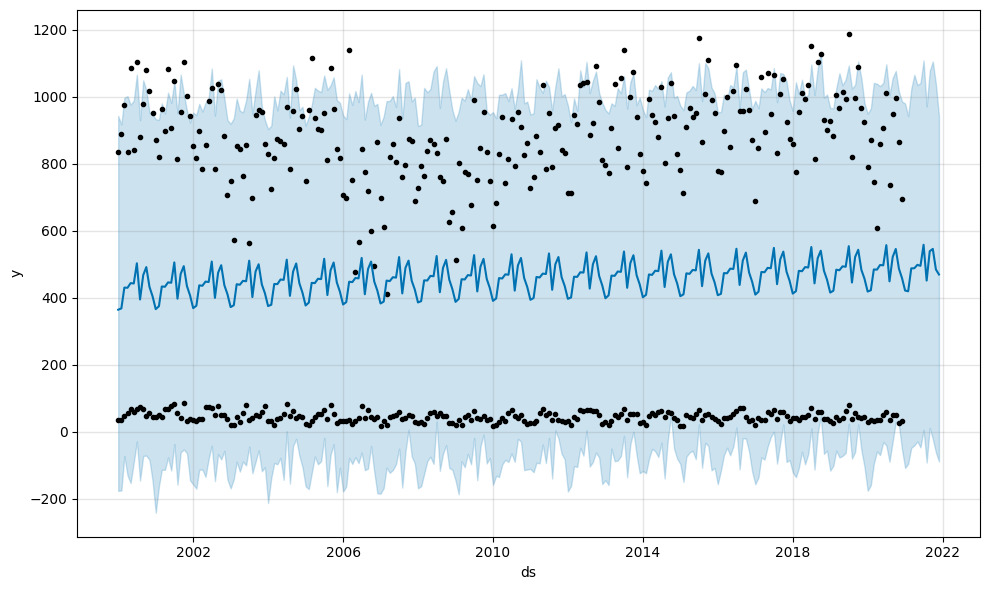

In [62]:
fig_escape = model_escape.plot(forecast_escape)

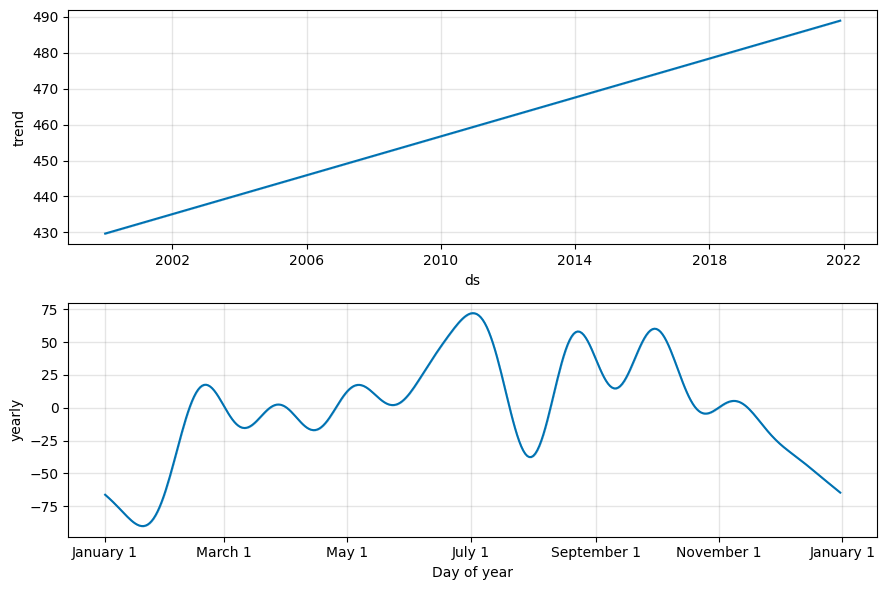

In [63]:
fig2 = model_escape.plot_components(forecast_escape)

### Traffic Accidents

In [64]:
df_traffic.describe()

,y,ds
count,756.000000,756
mean,1491.092593,2010-06-16 14:17:08.571428608
min,147.000000,2000-01-01 00:00:00
25%,414.000000,2005-03-24 06:00:00
50%,560.000000,2010-06-16 00:00:00
75%,3205.250000,2015-09-08 12:00:00
max,4763.000000,2020-12-01 00:00:00
std,1478.635750,NaN


In [65]:
model = Prophet()
model.fit(df_traffic)

18:14:02 - cmdstanpy - INFO - Chain [1] start processing
18:14:02 - cmdstanpy - INFO - Chain [1] done processing


In [66]:
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

In [67]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(24)

,ds,yhat,yhat_lower,yhat_upper
593,2021-11-08,1538.563779,-303.271478,3358.019548
594,2021-11-09,1533.729309,-246.784456,3412.331156
595,2021-11-10,1529.094136,-334.219591,3296.491133
596,2021-11-11,1524.751495,-340.199315,3420.462219
597,2021-11-12,1520.782480,-455.862365,3392.199376
598,2021-11-13,1517.252773,-248.150065,3403.954480
599,2021-11-14,1514.209934,-329.771158,3320.916024
600,2021-11-15,1511.681330,-317.018432,3426.407684
601,2021-11-16,1509.672797,-439.695159,3414.074783
602,2021-11-17,1508.168055,-412.218342,3257.601296


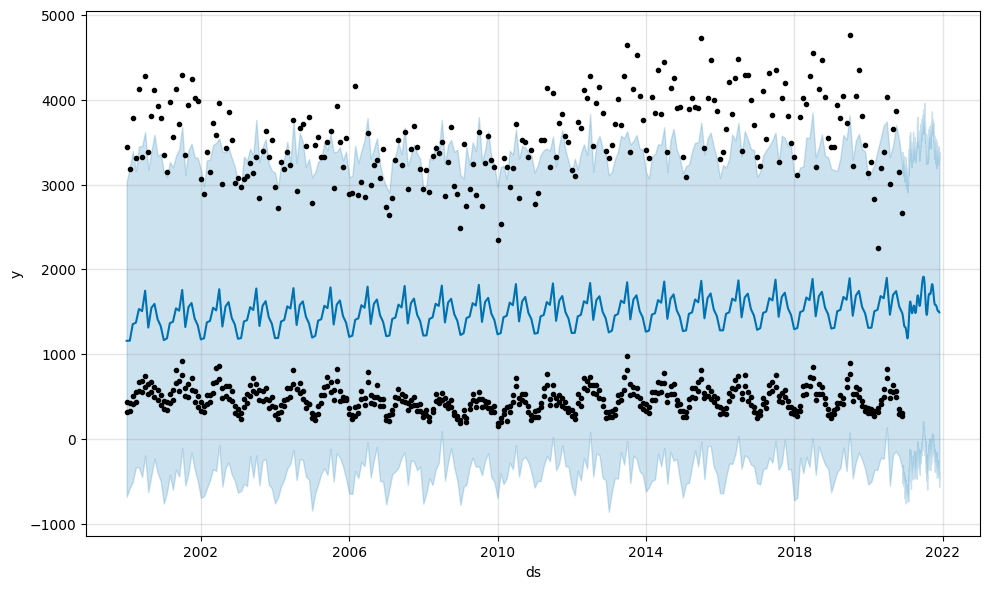

In [68]:
fig = model.plot(forecast)

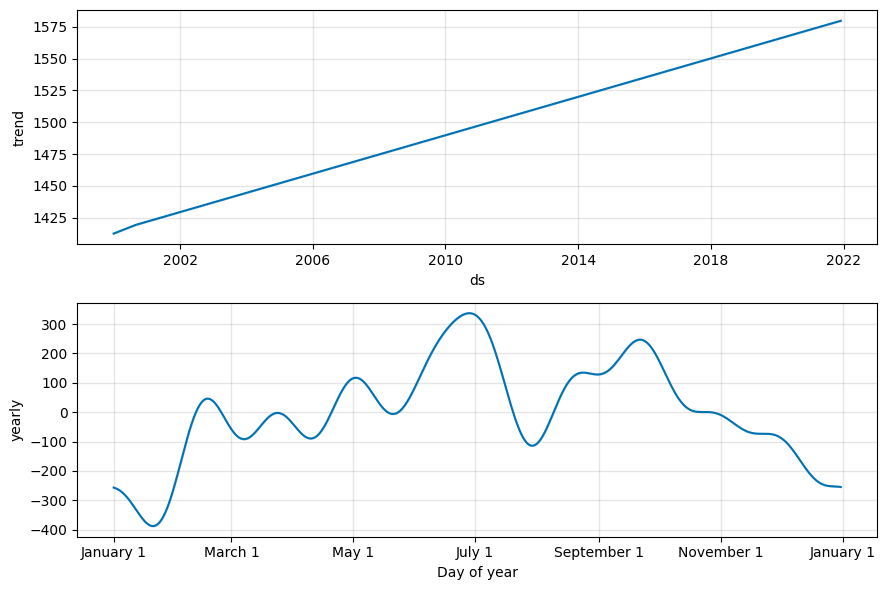

In [69]:
fig2 = model.plot_components(forecast)

# ARIMA Model

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import train_test_split

In [71]:
df.head()

,Month Count,CHARACTERISTIC,y,ds
1140,Escape accidents,Injured and killed,34.0,2000-01-01
1716,Traffic Accidents,with personal injury,321.0,2000-01-01
276,Alcohol Accidents,total,78.0,2000-01-01
852,Escape accidents,total,835.0,2000-01-01
1428,Traffic Accidents,total,3448.0,2000-01-01


In [72]:
# df.drop(columns=["ds_numeric"])

In [73]:
ts_df = df.set_index('ds')

In [74]:
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    print('Is the time series stationary? {0}'.format('No' if result[1] > 0.05 else 'Yes'))

In [75]:
# Function to plot ACF and PACF
def plot_acf_pacf(timeseries):
    fig, ax = plt.subplots(1, 2, figsize=(20, 4))
    plot_acf(timeseries, lags=30, ax=ax[0])
    plot_pacf(timeseries, lags=30, ax=ax[1])
    plt.show()

In [76]:
# Function to fit ARIMA model
def fit_arima_model(timeseries, order):
    model = SARIMAX(timeseries, order=order, enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit()
    return results

In [77]:
# Function to evaluate ARIMA model
def evaluate_arima_model(model, test_data):
    predictions = model.get_forecast(steps=len(test_data))
    
    # Extract numeric values from Timestamps
    predicted_mean_values = predictions.predicted_mean.values
    
    # Calculate Mean Squared Error
    mse = ((predicted_mean_values - test_data['y'].values) ** 2).mean()
    
    # Print Root Mean Squared Error
    print('Root Mean Squared Error (RMSE):', np.sqrt(mse))
    
    return predictions

In [78]:
check_stationarity(ts_df['y'])

ADF Statistic: -20.456865767486622
p-value: 0.0
Critical Values: {'1%': -3.4340794333632534, '5%': -2.863187337213453, '10%': -2.567646992971705}
Is the time series stationary? Yes


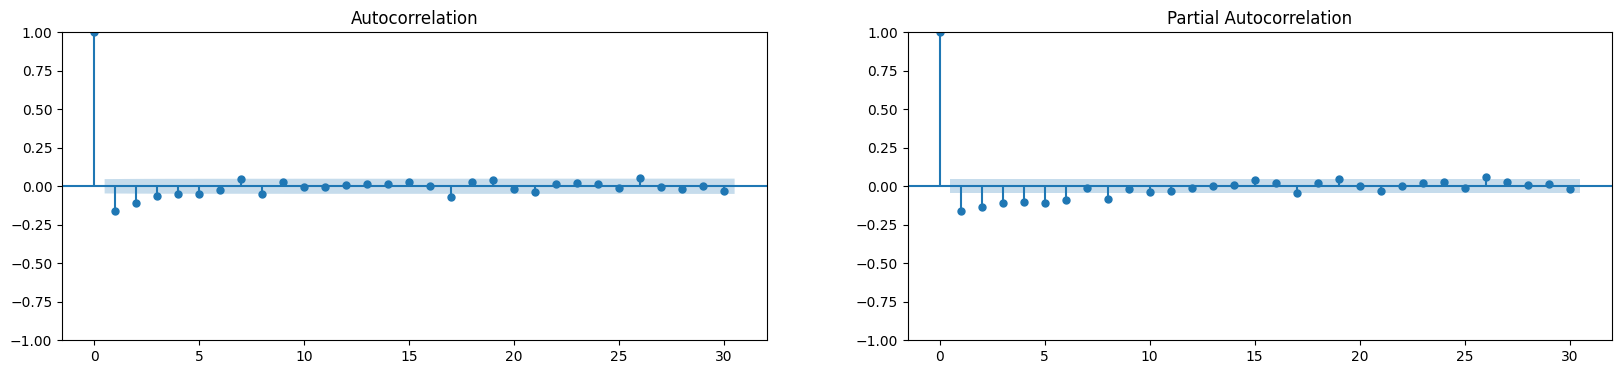

In [79]:
plot_acf_pacf(ts_df['y'])

In [80]:
train_size = int(len(ts_df) * 0.8)
train, test = ts_df.iloc[:train_size], ts_df.iloc[train_size:]

In [81]:
order = (0, 0, 0)

In [82]:
arima_model = fit_arima_model(train['y'], order)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.65882D+00    |proj g|=  5.05196D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   5.052D-07   8.659D+00
  F =   8.6588214090531217     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [83]:
arima_predictions = evaluate_arima_model(arima_model, test)

Root Mean Squared Error (RMSE): 1466.1091905585433


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


# XGBoost Modeling for Time Series Specifically

In [84]:
# extract the latest version of the dataset from W&B
run = wandb.init(project="traffic-accidents", job_type="update-dataset")
artifact = run.use_artifact("preprocessed_dataset:latest")
artifact_dir = artifact.download()
df = pd.read_csv(f"{artifact_dir}/preprocessed_dataset.csv")
wandb.finish()

wandb: Tracking run with wandb version 0.16.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231205_181409-3vzk62xx
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run flowing-wildflower-84
wandb: ⭐️ View project at https://wandb.ai/diksha-shrivastava13/traffic-accidents
wandb: 🚀 View run at https://wandb.ai/diksha-shrivastava13/traffic-accidents/runs/3vzk62xx
wandb:   1 of 1 files downloaded.  
wandb:                                                                                
wandb: 🚀 View run flowing-wildflower-84 at: https://wandb.ai/diksha-shrivastava13/traffic-accidents/runs/3vzk62xx
wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20231205_181409-3vzk62xx/logs


In [85]:
df.head()

,YEAR,MONTH,VALUE,Date,Month Count_Alcohol Accidents,Month Count_Escape accidents,Month Count_Traffic Accidents,CHARACTERISTIC_Injured and killed,CHARACTERISTIC_total,CHARACTERISTIC_with personal injury
0,2020,1,28.0,2020-01-01,1,0,0,0,1,0
1,2020,2,40.0,2020-02-01,1,0,0,0,1,0
2,2020,3,27.0,2020-03-01,1,0,0,0,1,0
3,2020,4,26.0,2020-04-01,1,0,0,0,1,0
4,2020,5,40.0,2020-05-01,1,0,0,0,1,0


In [86]:
df_sorted = df.sort_values(by='Date')

In [87]:
window_size = 10
df['target'] = df['VALUE'].shift(-window_size)
df = df[:-window_size]

In [88]:
df.head()

,YEAR,MONTH,VALUE,Date,Month Count_Alcohol Accidents,Month Count_Escape accidents,Month Count_Traffic Accidents,CHARACTERISTIC_Injured and killed,CHARACTERISTIC_total,CHARACTERISTIC_with personal injury,target
0,2020,1,28.0,2020-01-01,1,0,0,0,1,0,23.0
1,2020,2,40.0,2020-02-01,1,0,0,0,1,0,13.0
2,2020,3,27.0,2020-03-01,1,0,0,0,1,0,22.0
3,2020,4,26.0,2020-04-01,1,0,0,0,1,0,28.0
4,2020,5,40.0,2020-05-01,1,0,0,0,1,0,34.0


In [89]:
train_percentage = 0.8
split_index = int(len(df_sorted) * train_percentage)
train_set = df_sorted[:split_index]
test_set = df_sorted[split_index:]
train_set = train_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

In [90]:
X_train, y_train = train_set.drop(columns=["Date", "VALUE"]), train_set["VALUE"]
X_test, y_test = test_set.drop(columns=["Date", "VALUE"]), test_set["VALUE"]

In [91]:
model = XGBRegressor(
    max_depth=5,
    n_estimators=415,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse",  
    verbose=True)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared (R2) Score: {r2:.4f}')

Root Mean Squared Error (RMSE): 179.2515
R-squared (R2) Score: 0.9787


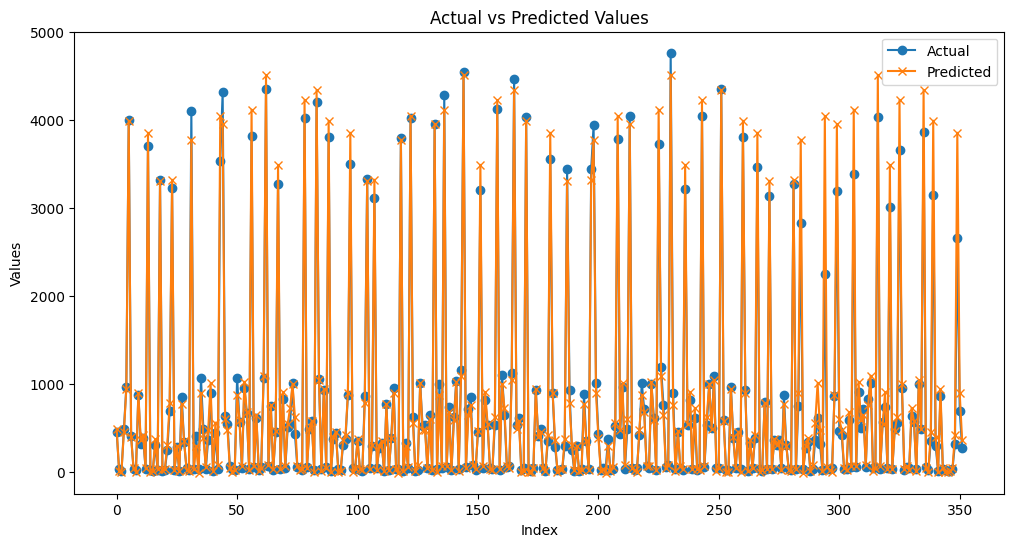

In [92]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

# Prophet: More Experiments

In [93]:
df_traffic.head()

,Month Count,CHARACTERISTIC,y,ds
1716,Traffic Accidents,with personal injury,321.0,2000-01-01
1428,Traffic Accidents,total,3448.0,2000-01-01
2004,Traffic Accidents,Injured and killed,434.0,2000-01-01
1717,Traffic Accidents,with personal injury,329.0,2000-02-01
1429,Traffic Accidents,total,3181.0,2000-02-01


In [94]:
df_alcohol.head()

,Month Count,CHARACTERISTIC,y,ds
276,Alcohol Accidents,total,78.0,2000-01-01
564,Alcohol Accidents,Injured and killed,37.0,2000-01-01
277,Alcohol Accidents,total,53.0,2000-02-01
565,Alcohol Accidents,Injured and killed,19.0,2000-02-01
278,Alcohol Accidents,total,73.0,2000-03-01


In [95]:
df_escape.head()

,Month Count,CHARACTERISTIC,y,ds
1140,Escape accidents,Injured and killed,34.0,2000-01-01
852,Escape accidents,total,835.0,2000-01-01
1141,Escape accidents,Injured and killed,35.0,2000-02-01
853,Escape accidents,total,890.0,2000-02-01
1142,Escape accidents,Injured and killed,48.0,2000-03-01


18:15:08 - cmdstanpy - INFO - Chain [1] start processing
18:15:08 - cmdstanpy - INFO - Chain [1] done processing


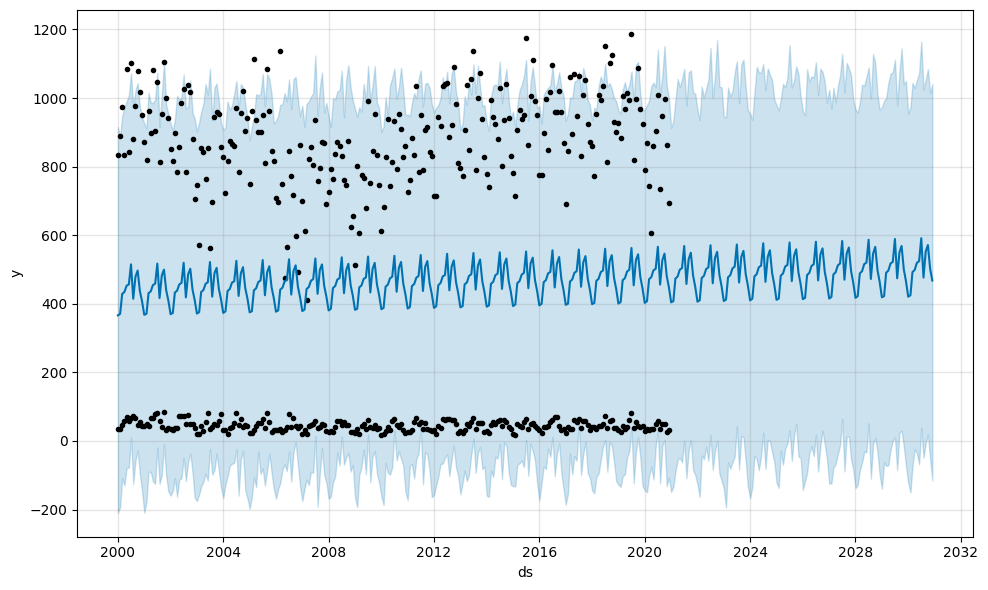

In [96]:
m = Prophet(seasonality_mode='multiplicative').fit(df_escape)
future = m.make_future_dataframe(periods=120, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)

18:15:10 - cmdstanpy - INFO - Chain [1] start processing
18:15:10 - cmdstanpy - INFO - Chain [1] done processing


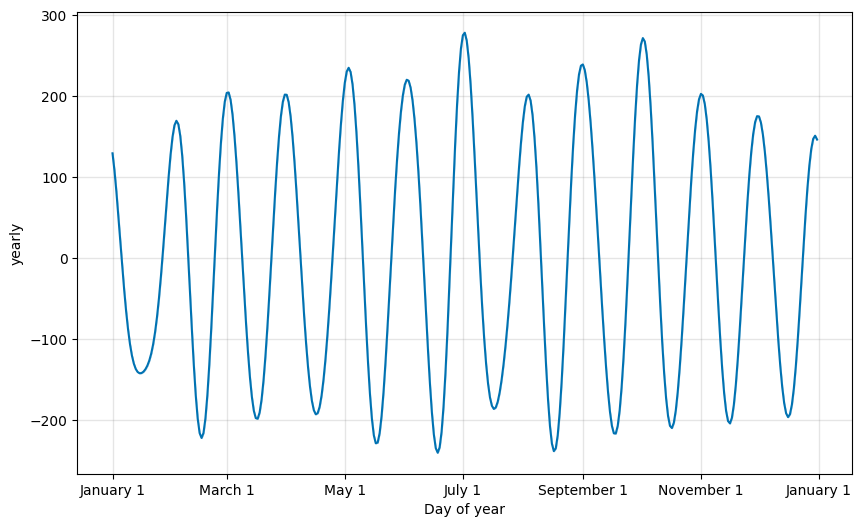

In [97]:
from prophet.plot import plot_yearly
m = Prophet(yearly_seasonality=20).fit(df_escape)
a = plot_yearly(m)

18:15:11 - cmdstanpy - INFO - Chain [1] start processing
18:15:11 - cmdstanpy - INFO - Chain [1] done processing


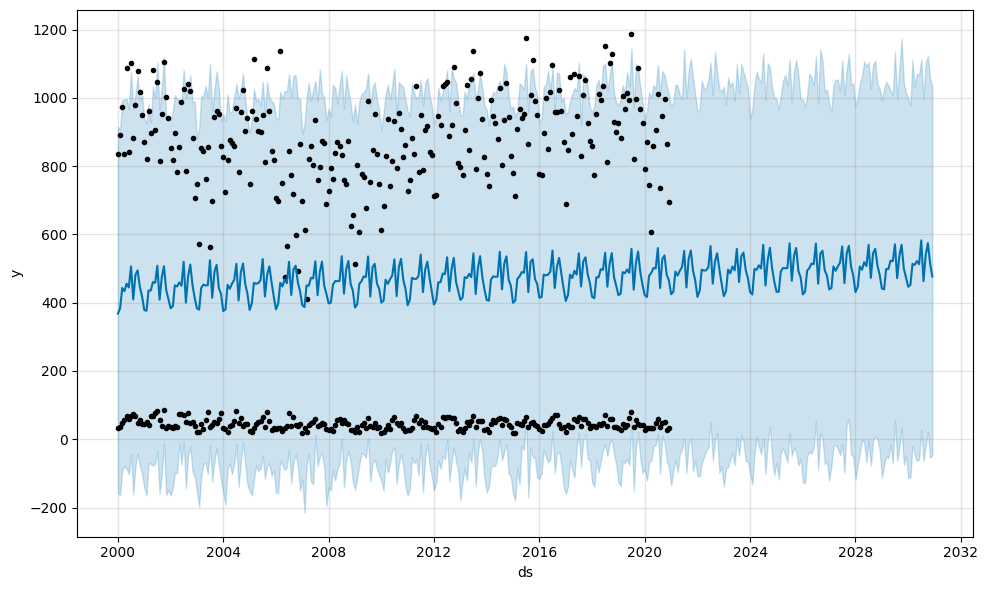

In [98]:
# Python
m = Prophet(changepoint_prior_scale=0.05, seasonality_prior_scale=10)
m.add_seasonality(
    name='weekly', period=7, fourier_order=3, prior_scale=0.1)
m.fit(df_escape)
future = m.make_future_dataframe(periods=120, freq='MS')
fcst = m.predict(future)
fig = m.plot(fcst)

In [99]:
predicted_values = forecast[['ds', 'yhat']]
merged_df = pd.merge(df_escape, predicted_values, on='ds', how='outer')

In [100]:
df_escape

,Month Count,CHARACTERISTIC,y,ds
1140,Escape accidents,Injured and killed,34.0,2000-01-01
852,Escape accidents,total,835.0,2000-01-01
1141,Escape accidents,Injured and killed,35.0,2000-02-01
853,Escape accidents,total,890.0,2000-02-01
1142,Escape accidents,Injured and killed,48.0,2000-03-01
...,...,...,...,...
909,Escape accidents,Injured and killed,50.0,2020-10-01
910,Escape accidents,Injured and killed,27.0,2020-11-01
622,Escape accidents,total,864.0,2020-11-01
623,Escape accidents,total,694.0,2020-12-01


In [101]:
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'y' is your actual values and 'yhat' is the predicted values
y_actual = merged_df['y'][:504]
y_predicted = merged_df['yhat'][:504]

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_actual, y_predicted)

# Calculate R-squared
r_squared = r2_score(y_actual, y_predicted)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared: {r_squared}')

Mean Squared Error (MSE): 1267862.9880518194
R-squared: -5.915684609442454


Prophet uses a linear model under the hood. That is most likely the reason for poor performance.

# SARIMAX Model

In [102]:
# extract the latest version of the dataset from W&B
run = wandb.init(project="traffic-accidents", job_type="update-dataset")
artifact = run.use_artifact("dataset:latest")
artifact_dir = artifact.download()
df = pd.read_csv(f"{artifact_dir}/translated_dataset.csv")
wandb.finish()

wandb: Tracking run with wandb version 0.16.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231205_181513-j5vvmy9r
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fragrant-dew-85
wandb: ⭐️ View project at https://wandb.ai/diksha-shrivastava13/traffic-accidents
wandb: 🚀 View run at https://wandb.ai/diksha-shrivastava13/traffic-accidents/runs/j5vvmy9r
wandb:   1 of 1 files downloaded.  
wandb:                                                                                
wandb: 🚀 View run fragrant-dew-85 at: https://wandb.ai/diksha-shrivastava13/traffic-accidents/runs/j5vvmy9r
wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20231205_181513-j5vvmy9r/logs


In [103]:
df.head()

,Month Count,CHARACTERISTIC,YEAR,MONTH,VALUE,PREVIOUS YEAR'S VALUE,Change Previous Month Percentage,Change Previous Year's Month,TWELVE_MONTHS_MEAN
0,Alcohol Accidents,total,2023,202301,NaN,NaN,NaN,NaN,NaN
1,Alcohol Accidents,total,2023,202302,NaN,NaN,NaN,NaN,NaN
2,Alcohol Accidents,total,2023,202303,NaN,NaN,NaN,NaN,NaN
3,Alcohol Accidents,total,2023,202304,NaN,NaN,NaN,NaN,NaN
4,Alcohol Accidents,total,2023,202305,NaN,NaN,NaN,NaN,NaN


In [104]:
df['MONTH'] = df['MONTH'] % 100
df['ds'] = pd.to_datetime(df[['YEAR', 'MONTH']].assign(DAY=1))
df.drop(['YEAR', 'MONTH'], axis=1, inplace=True)
df.rename(columns={'VALUE': 'y'}, inplace=True)
df = df.drop(columns=["PREVIOUS YEAR'S VALUE", 'Change Previous Month Percentage', "Change Previous Year's Month", 'TWELVE_MONTHS_MEAN'])
df = df[df['ds'].dt.year <= 2020]
df['Month Count'] = df['Month Count'].replace({'Accidents, Traffic': 'Traffic Accidents'})
df = df.sort_values(by='ds')

In [105]:
df.head()

,Month Count,CHARACTERISTIC,y,ds
1140,Escape accidents,Injured and killed,34.0,2000-01-01
1716,Traffic Accidents,with personal injury,321.0,2000-01-01
276,Alcohol Accidents,total,78.0,2000-01-01
852,Escape accidents,total,835.0,2000-01-01
1428,Traffic Accidents,total,3448.0,2000-01-01


In [106]:
accident_type = "total"
data = df[(df.CHARACTERISTIC == accident_type)].groupby("ds").y.sum()

In [107]:
data

ds
2000-01-01    4361.0
2000-02-01    4124.0
2000-03-01    4830.0
2000-04-01    4229.0
2000-05-01    5305.0
               ...  
2020-08-01    3788.0
2020-09-01    4653.0
2020-10-01    4898.0
2020-11-01    4037.0
2020-12-01    3368.0
Name: y, Length: 252, dtype: float64

In [108]:
data_cut = data.index > "2000-01-01"
recent_data = data[data_cut]
train_cut = recent_data.index >= "2018-12-01"
train, test = recent_data[~train_cut], recent_data[train_cut]

In [109]:
train

ds
2000-02-01    4124.0
2000-03-01    4830.0
2000-04-01    4229.0
2000-05-01    5305.0
2000-06-01    4228.0
               ...  
2018-07-01    5749.0
2018-08-01    4059.0
2018-09-01    5262.0
2018-10-01    5638.0
2018-11-01    4987.0
Name: y, Length: 226, dtype: float64

In [110]:
test

ds
2018-12-01    4471.0
2019-01-01    4389.0
2019-02-01    4353.0
2019-03-01    4979.0
2019-04-01    4784.0
2019-05-01    5099.0
2019-06-01    4761.0
2019-07-01    5998.0
2019-08-01    4065.0
2019-09-01    5085.0
2019-10-01    5481.0
2019-11-01    4801.0
2019-12-01    4422.0
2020-01-01    3958.0
2020-02-01    4181.0
2020-03-01    3596.0
2020-04-01    2884.0
2020-05-01    4092.0
2020-06-01    4334.0
2020-07-01    5099.0
2020-08-01    3788.0
2020-09-01    4653.0
2020-10-01    4898.0
2020-11-01    4037.0
2020-12-01    3368.0
Name: y, dtype: float64

In [111]:
from datetime import datetime
import pandas as pd
from dateutil.relativedelta import relativedelta
from sklearn.base import BaseEstimator

def create_timeindex(end_date: datetime, n_steps: int) -> pd.DatetimeIndex:
    return pd.date_range(
        start=end_date + relativedelta(months=1), periods=n_steps, freq="MS"
    )


class NamedModel:
    @property
    def name(self):
        return f"{self.__class__.__name__}"
    
class StatsInterface:

    def forecast(self, steps: int):
        return self.predict(steps)
    
    
class Persistence(BaseEstimator, NamedModel, StatsInterface):
    def __init__(self) -> None:
        super().__init__()
        self.last_value = None

    def fit(self, X, y=None):
        self.last_value = X.iloc[-1]
        self.end_date = X.index[-1]
        return self

    def predict(self, n_steps: int) -> pd.Series:
        return pd.Series(
            [self.last_value] * n_steps,
            index=create_timeindex(self.end_date, n_steps),
            name=self.name,
        )
class Average(BaseEstimator, NamedModel, StatsInterface):
    def __init__(self, window: int) -> None:
        super().__init__()
        self.window = window

    def fit(self, X, y=None):
        self.data = X.iloc[-self.window :]
        self.end_date = X.index[-1]
        return self

    def predict(self, n_steps: int) -> pd.Series:
        index = create_timeindex(self.end_date, n_steps)
        return pd.Series(
            [self.data.mean()] * n_steps, index=index, name=self.name
        )
    
class Seasonal(BaseEstimator, NamedModel, StatsInterface):
    def __init__(self, freq: int) -> None:
        super().__init__()
        self.freq = freq

    def fit(self, X, y=None):
        self.data = X.iloc[-self.freq :]
        self.end_date = X.index[-1]
        return self

    def predict(self, n_steps: int) -> pd.Series:
        index = create_timeindex(self.end_date, n_steps)
        return pd.Series(
            [self.data[i % self.freq] for i in range(n_steps)],
            index=index,
            name=self.name,
        )

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.46631D+00    |proj g|=  1.10729D-01

At iterate    5    f=  7.42152D+00    |proj g|=  2.49109D-02

At iterate   10    f=  7.41134D+00    |proj g|=  1.13071D-03

At iterate   15    f=  7.41035D+00    |proj g|=  5.26420D-03

At iterate   20    f=  7.34072D+00    |proj g|=  5.37512D-02

At iterate   25    f=  7.25693D+00    |proj g|=  7.89362D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     54      1     0     0   

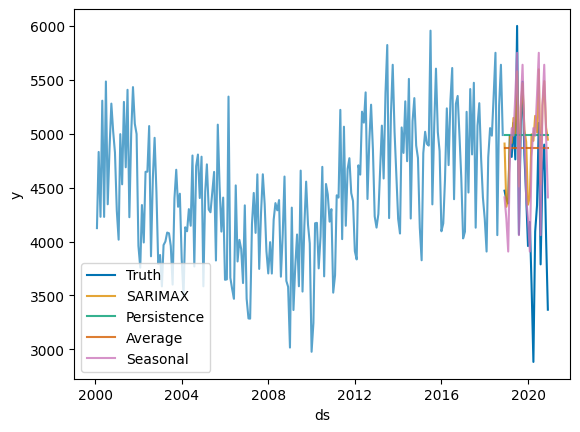

In [112]:
sns.set_palette("colorblind")

fig, ax = plt.subplots()

sns.lineplot(train, alpha = .66)
sns.lineplot(test, c = sns.color_palette()[0], label = "Truth")

n_steps = test.shape[0]

preds_alpha = .8
model_preds = {}

from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12)).fit()
preds = model.forecast(steps = n_steps)
sns.lineplot(preds, ax=ax, label = "SARIMAX", alpha = preds_alpha)
model_preds["SARIMAX"] = (model, preds)

for model in (Persistence(), Average(12), Seasonal(12)):
    model.fit(train)
    preds = model.forecast(n_steps)
    model_preds[model.name] = (model, preds)
    plt.plot(preds.index, preds.values, label = model.name, alpha = preds_alpha)

plt.legend(loc = "lower left")

# SKTime Model

In [113]:
!pip install sktime

  Obtaining dependency information for sktime from https://files.pythonhosted.org/packages/76/59/a61df85f9e36a2174e544f99e87be4d62e1f502216db2cb3e75be8e7174b/sktime-0.24.1-py3-none-any.whl.metadata
  Obtaining dependency information for scikit-base<0.7.0 from https://files.pythonhosted.org/packages/ba/5d/cf3d9ae370bc67f6d81f54a7f80656ef5b88635f67fb2339f1a0eb666551/scikit_base-0.6.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.7/20.7 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 8.1 MB/s eta 0:00:00


In [114]:
df.head()

,Month Count,CHARACTERISTIC,y,ds
1140,Escape accidents,Injured and killed,34.0,2000-01-01
1716,Traffic Accidents,with personal injury,321.0,2000-01-01
276,Alcohol Accidents,total,78.0,2000-01-01
852,Escape accidents,total,835.0,2000-01-01
1428,Traffic Accidents,total,3448.0,2000-01-01


In [115]:
train_percentage = 0.8
split_index = int(len(df) * train_percentage)
train_set = df[:split_index]
test_set = df[split_index:]
train_set = train_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

In [116]:
train_set

,Month Count,CHARACTERISTIC,y,ds
0,Escape accidents,Injured and killed,34.0,2000-01-01
1,Traffic Accidents,with personal injury,321.0,2000-01-01
2,Alcohol Accidents,total,78.0,2000-01-01
3,Escape accidents,total,835.0,2000-01-01
4,Traffic Accidents,total,3448.0,2000-01-01
...,...,...,...,...
1406,Traffic Accidents,total,4289.0,2016-09-01
1407,Traffic Accidents,with personal injury,448.0,2016-10-01
1408,Escape accidents,total,1022.0,2016-10-01
1409,Alcohol Accidents,Injured and killed,11.0,2016-10-01


In [117]:
!pip install pmdarima

  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/ec/2b/e7d18360d56396b62781ba4616527af49244d4bed51f0780646fa3953cc8/pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.6 MB/s eta 0:00:00


(<Figure size 1600x400 with 1 Axes>, <Axes: >)

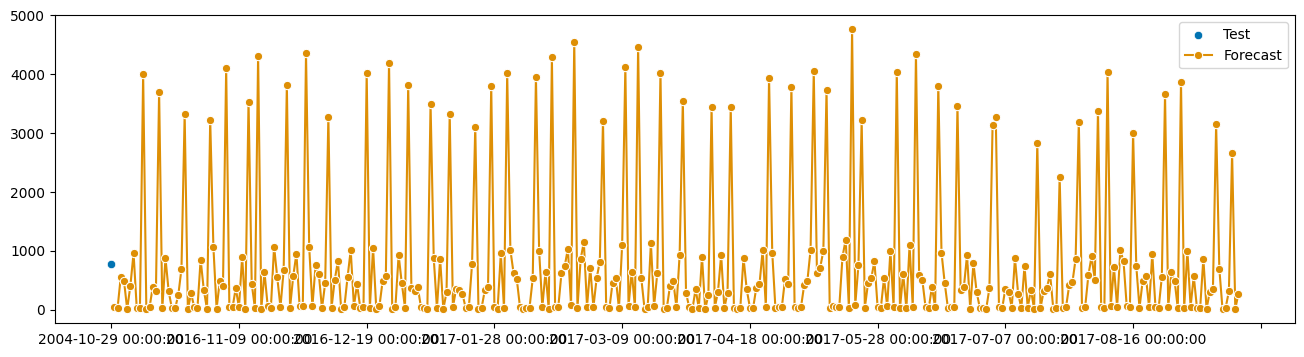

In [118]:
# train_set = df.loc[df['ds'] < '2021-12-01']
# test_set = df.loc[df['ds'] >= '2021-12-01']
import pandas as pd
from sktime.forecasting.arima import AutoARIMA
from sktime.utils.plotting import plot_series

freq = 'D'

train_series = pd.Series(train_set['y'].values, index=pd.date_range(start=train_set['ds'].min(), periods=len(train_set), freq=freq))
test_series = pd.Series(test_set['y'].values, index=pd.date_range(start=test_set['ds'].min(), periods=len(test_set), freq=freq))

# Create and fit the AutoARIMA model
model = AutoARIMA(sp=12, suppress_warnings=True)
model.fit(train_series)

# Make predictions on the test set
forecast = model.predict(fh=len(test_series))

# Plot the results
plot_series(forecast, test_series, labels=["Test", "Forecast"])

In [119]:
len(test_series)

353

In [120]:
fh = list(range(1, len(test_series) + 1))
forecast = model.predict(fh=fh)

In [121]:
fh = pd.date_range(start=test_series.index[0], periods=len(test_series), freq=freq)

# Make predictions on the test set with the specified forecasting horizon
forecast = model.predict(fh=fh)

In [122]:
forecast

2016-10-01    773.409301
2016-10-02    773.409301
2016-10-03    773.409301
2016-10-04    773.409301
2016-10-05    773.409301
                 ...    
2017-09-14    773.409301
2017-09-15    773.409301
2017-09-16    773.409301
2017-09-17    773.409301
2017-09-18    773.409301
Freq: D, Length: 353, dtype: float64

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

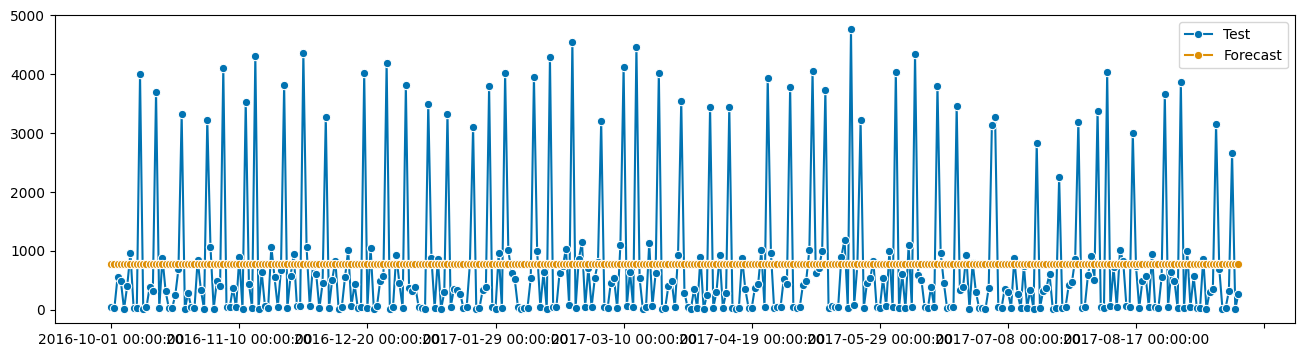

In [123]:
plot_series(test_series, forecast, labels=["Test", "Forecast"])

In [124]:
forecast

2016-10-01    773.409301
2016-10-02    773.409301
2016-10-03    773.409301
2016-10-04    773.409301
2016-10-05    773.409301
                 ...    
2017-09-14    773.409301
2017-09-15    773.409301
2017-09-16    773.409301
2017-09-17    773.409301
2017-09-18    773.409301
Freq: D, Length: 353, dtype: float64

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

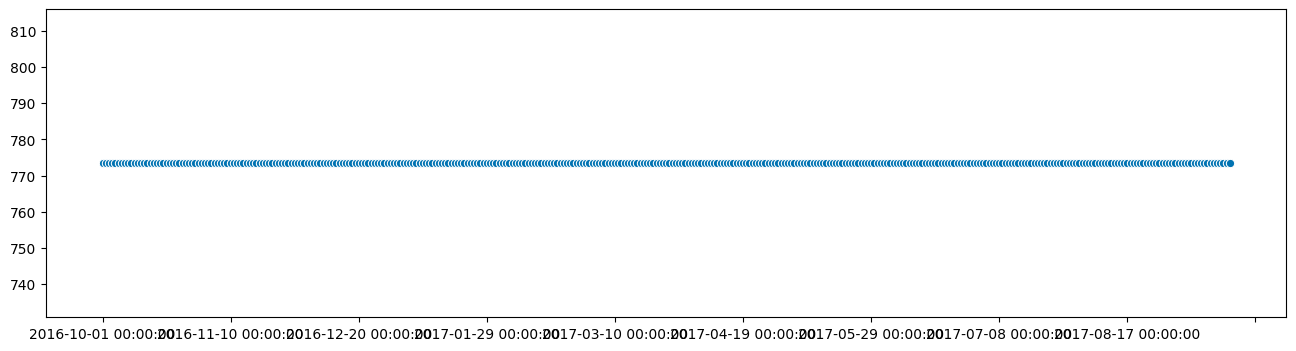

In [125]:
plot_series(forecast)

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

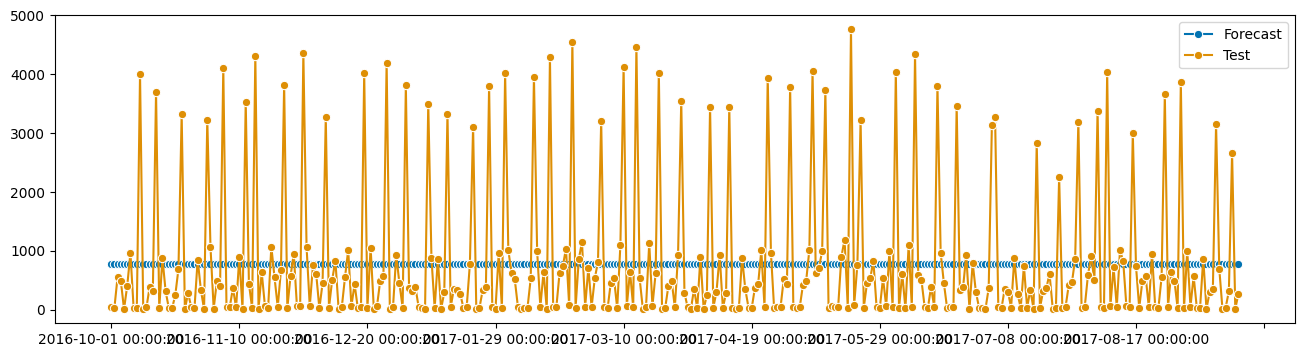

In [126]:
plot_series(forecast, test_series, labels=["Forecast", "Test"])

In [127]:
# # X_train, y_train = load_covid_3month(split="train")
# # y_train = y_train.astype("float")
# # X_new, _ = load_covid_3month(split="test")
# # X_new = X_new.loc[:2]  # smaller dataset for faster notebook runtime

# # step 3 - specify the regressor
# from sktime.regression.distance_based import KNeighborsTimeSeriesRegressor
# from sktime.dists_kernels import FlatDist, ScipyDist
# # from sktime.utils.data_processing import from_2d_array_to_dataframe

# # # Assuming X_train and X_test are DataFrames
# # # Convert X_train and X_test to nested format
# # X_train_nested = from_2d_array_to_nested(X_train.values)
# # X_test_nested = from_2d_array_to_nested(X_test.values)

# # # Ensure y_train and y_test are in the expected format (convert if needed)
# # y_train_array = y_train.values.reshape(-1, 1)
# # y_test_array = y_test.values.reshape(-1, 1)


# eucl_dist = FlatDist(ScipyDist())
# clf = KNeighborsTimeSeriesRegressor(n_neighbors=3, distance=eucl_dist)

# # step 4 - fit/train the regressor
# clf.fit(X_train, y_train)

# # step 5 - predict labels on new data
# y_pred = clf.predict(X_test_nested)